# Reinforcement Learning Control of Cart-Pole System

### Import Statements

In [1]:
import gym
from gym import spaces
import numpy as np
import math
import matplotlib.pyplot as plt
import pygame
from pygame import gfxdraw
from typing import Union
from scipy import stats
import cv2

### Enviroment

In [2]:
class CartPoleEnv(gym.Env):

    meta_data = {'render_modes': ['human', 'rgb_array'], 'render_fps': 50}

    ## initialize attributes to object ## 
    def __init__(self, render_mode: Union[str, None] = None):
        
        # dynamical system attributes
        self.gravity = 9.81
        self.cart_mass = 1
        self.pole_mass = 0.1
        self.pole_length = 0.5 # half the pole's actual length
        self.total_mass = (self.pole_mass + self.cart_mass) 
        self.force = 10 
        self.tau = 0.02 # time between state updates
        self.pole_mass_length = self.pole_mass * self.pole_length

        # constraint attributes
        self.theta_threshold = 0.2094
        self.x_threshold = 2.4

        # make the observation space twice as large as constraint space in theta and x directions
        # set no constraint on the theta_dot and x_dot 
        max = np.array(
            [
                self.theta_threshold*2,
                np.finfo(np.float32).max,
                self.theta_threshold*2,
                np.finfo(np.float32).max
            ],
            dtype=np.float32
        )

        # space attributes
        self.action_space = spaces.Discrete(2) # 2 dimensional action space
        self.observation_space = spaces.Box(-max,max,dtype=np.float32) # 4 dimensional observation space
        
        # render attribute
        self.render_mode = render_mode

        # display attributes
        self.window_width = 600
        self.window_height = 400
        self.window = None
        self.clock = None
        self.isopen = True
        self.state = None
        
    ## update observation attributes ##
    def step(self, action):
        
        x, x_dot, theta, theta_dot = self.state # current observation
        
        # determine direction of force (action)
        if action == 1:
            force = self.force
        else:
            force = -self.force

        cos = math.cos(theta)
        sin = math.sin(theta)

        # eulers method, refer to: https://en.wikipedia.org/wiki/Euler_method
        # solve differential equations of inverted cart pendulum system (state 0.02s later), refer to equation # in the report
        temp = (force + self.pole_mass_length * theta_dot**2 * sin) / self.total_mass
        
        theta_accel = (self.gravity * sin - cos * temp) / (self.pole_length * (4.0 / 3.0 - (self.pole_mass * cos**2) / self.total_mass))

        x_accel = temp - self.pole_mass_length * theta_accel * cos / self.total_mass

        x = x + self.tau * x_dot
        x_dot = x_dot + self.tau * x_accel
        theta = theta + self.tau * theta_dot
        theta_dot = theta_dot + self.tau * theta_accel

        self.state = (x,x_dot,theta,theta_dot) # update observation with obtained numerical solutions

        # test if updated observation satisfies constraints
        terminated = bool(
            theta < -self.theta_threshold
            or theta > self.theta_threshold
            or x < -self.x_threshold
            or x > self.x_threshold
        )

        # render frame after updated observation
        if self.render_mode == self.meta_data['render_modes'][0]: 
            self.render()
        
        return np.array(self.state, dtype=np.float32), terminated, False , {}
    
    ## reset observation attributes ##
    def reset(self, seed: Union[int,None] = None, options: Union[str,None] = None):
        
        # if options arg is None insert empty dictionary
        if options is None:
            options = {}
        
        super().reset(seed=seed) # required to make sure gym.Env seeds self.np_random

        self.state = self.np_random.normal(loc=0,scale=0.01,size=(4,)) # reset observation with gaussian normal distribution centered around 0 and small standard deviation   

        # render frame after observation is reset
        if self.render_mode == self.meta_data['render_modes'][0]:
            self.render()

        return np.array(self.state, dtype=np.float32), {}
    
    ## render display window ##
    def render(self):     

        if self.window is None:
            pygame.init() # initialize pygame modules
            if self.render_mode == 'human': 
                pygame.display.init() # initialize display module
                self.window = pygame.display.set_mode((self.window_width,self.window_height)) # create display surface
            else:  # render_mode == "rgb_array"
                self.window = pygame.Surface((self.window_width, self.window_height)) # create image surface
        
        if self.clock is None:
            self.clock = pygame.time.Clock() # create clock object
        
        # display window parameters
        env_width = self.x_threshold * 2 # environment width
        scale = self.window_width/env_width # scale factor between environment and display window
        pole_width = 10.0
        pole_height = scale * (2 * self.pole_length)
        cart_width = 50.0
        cart_height = 30.0

        self.surf = pygame.Surface((self.window_width, self.window_height)) # create image surface
        self.surf.fill((255,255,255)) # colour image white
        
        x = self.state # current observation
        l, r, b, t = -cart_width / 2.0, cart_width / 2.0, -cart_height / 2.0, cart_height / 2.0 # side positions of cart
        pivot_offset = cart_height / 4.0 # height of pivot point
        x_cart = x[0] * scale + self.window_width / 2.0 # center of cart in x
        y_cart = 100 # top of cart in y
        cart_coordinates = [(l,b),(l,t),(r,t),(r,b)] # vertices of cart
        cart_coordinates = [(c[0] + x_cart, c[1] + y_cart) for c in cart_coordinates] # coordinate list of cart
        
        # drawing the cart
        gfxdraw.aapolygon(self.surf, cart_coordinates, (0,0,0)) # trace a polygon in black 
        gfxdraw.filled_polygon(self.surf, cart_coordinates, (0,0,0)) # colour the polygon black

        l, r, b, t = -pole_width / 2.0, pole_width / 2.0, -pole_width / 2.0, pole_height - pole_width / 2.0 # side positions of pole
        pole_coordinates = [] # coordinate list of pole
        for coordinate in [(l,b),(l,t),(r,t),(r,b)]:
            coordinate =  pygame.math.Vector2(coordinate).rotate_rad(-x[2])
            coordinate = (coordinate[0] + x_cart, coordinate[1] + y_cart + pivot_offset)
            pole_coordinates.append(coordinate)

        # drawing the pole
        gfxdraw.aapolygon(self.surf, pole_coordinates, (139,69,19)) # trace a polygon in black 
        gfxdraw.filled_polygon(self.surf, pole_coordinates, (139,69,19)) # colour the polygon black

        # drawing the pivot
        gfxdraw.aacircle(self.surf, int(x_cart), int(y_cart + pivot_offset), int(pole_width / 2), (112,128,144))
        gfxdraw.filled_circle(self.surf, int(x_cart), int(y_cart + pivot_offset), int(pole_width / 2), (112,128,144))

        gfxdraw.hline(self.surf, 0, self.window_width, y_cart, (0,0,0)) # draw horizontal line through center of cart in y
        self.surf = pygame.transform.flip(self.surf, False, True) # flip image horizontally
        self.window.blit(self.surf, (0,0)) # draw image on window

        if self.render_mode == 'human':
            pygame.event.pump() # process pending events
            self.clock.tick(self.meta_data['render_fps']) # set the frame rate
            pygame.display.flip() # update the contents of the display

        elif self.render_mode == 'rgb_array':
            return np.transpose(np.array(pygame.surfarray.pixels3d(self.window)), axes=(1, 0, 2)) # convert pygame image to numpy array
    
    ## close render display ## 
    def close(self):
        
        if self.window is not None: # check if pygame window is open
            pygame.display.quit() # close pygame window
            pygame.quit() # uninitialize pygame modules
            self.isopen = False # update isopen attribute to indicate pygame is closed


### Q-Learning

In [3]:
## parameter definitions ##

# environment
render_modes = CartPoleEnv.meta_data['render_modes'] # store list of the available render modes
env = CartPoleEnv(render_modes[1]) # create instance of environment
action_space = env.action_space.n # get dimensions of action space
observation_space = len(env.observation_space.high) # get dimensions of observation space
num_bins = 30 # number of bins in each dimension of discretized observation space
# hyperparameters (bellman equation)
gamma = 0.95 # measure of how important earlier rewards are compared to later ones
alpha_f = 0.15 # measure of how quickly the algorithm aquires new information that replaces old
alpha_i = 1
epsilon_i = 1 # epsilon: measure of the amount of random actions taken
epsilon_f = 0.1 
# run time
episodes = 1250 # maximum number of episodes
max_steps = 1000 # maximum number of actions
show_time = 100 # output interval

## generate Q-table ## 
def Q_table(action_space, observation_space, num_bins):

    # find size of each bucket
    bins = [
            np.linspace(-4.8, 4.8, num_bins),
            np.linspace(-4, 4, num_bins),
            np.linspace(-.418, .418, num_bins),
            np.linspace(-4, 4, num_bins)
        ]
    
    # initialize q-table with gaussian normal distribution centered around 0 and small standard deviation
    q_table = np.random.normal(loc=0, scale=0.01, size=([num_bins]*observation_space + [action_space]))
    
    return q_table, bins

## discretize observation ##
def discretize(observation, bins):

    index = [] # index in discretized space representing the approximate continuous state value

    # map the continuous state value to approximate discrete value for all dimensions of the observation space
    # note: the continuous state value is a numerical approximation of the system of modelled ODE's using eulers method
    for i in range(len(observation)): 
        index.append(np.digitize(observation[i],bins[i])-1)

    return tuple(index)

## intermediate angle reward function ##
def reward_pole(theta,terminated):

    target = 0 # target angle
    max_reward = 10 # reward if at target angle
    min_reward = 0 # reward if termination condition is met
    theta_deg = (theta*180)/math.pi
    angle_disp = np.abs(theta_deg-target) # angular displacement between target and current angle

    if not terminated:
        reward = max_reward - 0.58333 * angle_disp # linear interpolation between min and max reward for input 0 to 12 degrees angular displacement
    else:
        reward = min_reward

    return reward

## intermediate position reward function ##
def reward_cart(position,terminated):

    target = 0 # target position
    max_reward = 5 # reward if at target position
    min_reward = 0 # reward if at termination condition is met
    pos_disp = np.abs(position-target) # displacement between target and current position

    if not terminated:
        reward2 = max_reward - 0.83333 * pos_disp # linear interpolation between min and max reward for input 0 to 2.4 meters displacement
    else:
        reward2 = min_reward

    return reward2

## time balanced reward function ##
def reward_balanced(steps, terminated):

    reward_factor = 0.002 # max reward: reward_factor*max_steps
    min_reward = 0 # reward if at termination condition is met

    if not terminated:
        reward3 = reward_factor * steps # linear interpolation between min_reward and reward_factor*max_steps
    else:
        reward3 = min_reward

    return reward3

## learn optimal policy ##
def Q_learning(q_table, bins, episodes, show_time, gamma, epsilon_i, epsilon_f, alpha_i, alpha_f, render_mode):

    episode_rewards = [] # list of episode rewards
    episode_steps = [] # list of episode steps
    epsilon_plot = [] # list of epsilon values over episodes
    alpha_plot = [] # list of alpha values over episodes
    best_episode_reward = 0 # initialize best episode reward

    for episode in range(episodes):
        
        ## initialization ##
        
        truncated = False # set constriant variables to false 
        terminated = False
        episode_reward = 0 # episode reward sum
        steps = 0 # sum of steps taken in the environment
        
        epsilon = epsilon_i * np.exp(-episode / (episodes / 2)) # exponential epsilon decay
        epsilon = max(epsilon,epsilon_f) # ensure epsilon does not exceed minimum value
        epsilon_plot.append(epsilon) 
        
        alpha = alpha_i * np.exp(-episode / (episodes / 1.75)) # exponential alpha decay
        alpha = max(alpha,alpha_f) # ensure epsilon does not exceed minimum value
        alpha_plot.append(alpha) 

        observation_continuous = env.reset(seed=None,options={})[0] # intial observation from modelled ODE's
        observation = discretize(observation_continuous,bins) # inital observation mapped to discretized space 

        cart_x = [observation_continuous[0]] # list of the episode's cart positions
        pole_theta = [observation_continuous[2]] # list of the episode's pole angles
        steps_plot = [steps] # list of the number of steps taken in the episode
        episode_frames = [] # list of the episode frames

        while not (terminated or truncated): # check if constraint variables are met

            steps += 1 # count the number of steps in the episode
            steps_plot.append(steps)

            # check if maximum number of steps is exceeded (truncated condition) 
            # note: environment does not check truncation condition
            if steps > max_steps-1:
                truncated = True

            ## determine action ##
            
            if np.random.uniform(0,1) < epsilon: # if epsilon is greater than the random number drawn from the uniform distribution 
                action = env.action_space.sample() # choose random action
            else:
                action = np.argmax(q_table[observation]) # choose action associated with maximum value function
            
            ## update observation ## 

            state, terminated, *_ = env.step(action) # take action in environment and check termination condition
            next_observation = discretize(state, bins) # map new state to discrete space

            cart_x.append(state[0])
            pole_theta.append(state[2])

            ## compute reward ##
            
            reward1 = reward_pole(state[2],terminated) # reward given based on angular displacement of pole
            episode_reward += reward1
            
            reward2 = reward_cart(state[0],terminated) # reward given based on displacement of cart
            episode_reward += reward2
           
            reward3 = reward_balanced(steps,terminated) # reward given based on the step number
            episode_reward += reward3
            
            reward = reward1 + reward2 + reward3 # sum rewards

            ## value iteration (update q-table) ## 
            
            if not (terminated or truncated): 
                q = q_table[observation + (action,)] # value function at current state-action pair
                max_future_q = np.max(q_table[next_observation]) # maximum q-value that can be obtained in the next state given all possible actions
                q_update = q + alpha * (reward + gamma * max_future_q - q) # compute maximum future reward
                q_table[observation + (action,)] = q_update # update value function at current state 
            observation = next_observation 

            ## render frames ##
            if render_mode == render_modes[0]:
                env.render() # frame for live pygame window
            elif render_mode == render_modes[1]:
                frame = env.render() # store frame as rgb array
                episode_frames.append(frame) 

        ## data analysis ## 

        # find episode with largeset reward and store the data for visulizations
        if episode_reward > best_episode_reward:
            best_episode_reward = episode_reward 
            best_episode_frames = episode_frames 
            best_steps_plot = steps_plot
            best_cart_x = cart_x 
            best_pole_theta = pole_theta  

        episode_rewards.append(episode_reward) # append current episode reward
        episode_steps.append(steps) # append current episode steps

        # display information on the show time interval
        if episodes % show_time == 0:
            print(f'Episode: {episode} | Reward: {episode_reward:.3f} | Epsilon: {epsilon:.3f} | Alpha {alpha:.3f} | Gamma {gamma:.3f}')

        # if episode reward exceeds the threshold then the pole is considered balanced
        if steps > 500: 
            print(f'Inverted pendulum has been balanced on episode {episode}')            
    
    ## further data analysis ##

    episodes_plot = np.linspace(0,episodes-1,episodes) # ascending list of episodes runned
    
    # plot cumulative reward vs episode
    plt.figure(1)
    plt.plot(episodes_plot,episode_rewards)
    #plt.title('Cumulative Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.grid(visible=True)
    # add trendline to figure 1
    z = np.polyfit(episodes_plot,episode_rewards,1)
    p = np.poly1d(z)
    plt.plot(episodes_plot,p(episodes_plot),'r-')
    slope, intercept, *_ = stats.linregress(episodes_plot,episode_rewards) # compute slope and intercept of trendline

    # plot cumulative steps vs episode
    plt.figure(2)
    plt.plot(episodes_plot,episode_steps)
    #plt.title('Cumulative Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Steps')
    plt.grid(visible=True)
    # add trendline to figure 2
    z = np.polyfit(episodes_plot,episode_steps,1)
    p = np.poly1d(z)
    plt.plot(episodes_plot,p(episodes_plot),'r-')

    # plot epsilon decay vs episode
    plt.figure(3)
    plt.plot(episodes_plot,epsilon_plot,label='Epsilon')
    #plt.title('Exponential Decay of Learning Rate and Exploration Factor')
    plt.xlabel('Episode')
    plt.plot(episodes_plot,alpha_plot,label='Alpha') # plot alpha decay on figure 2
    plt.legend()
    plt.grid(visible=True) 
    
    # plot cart position for best episode
    plt.figure(4)
    plt.plot(best_steps_plot,best_cart_x)
    #plt.title('Cart Position vs Time Step')
    plt.xlabel('Time Step')
    plt.ylabel('Cart Position')
    plt.grid(visible=True)
    
    # plot pole angle for best episode
    plt.figure(5)
    plt.plot(best_steps_plot,best_pole_theta)
    #plt.title('Pole Angle vs Time Step')
    plt.xlabel('Time Step')
    plt.ylabel('Pole Angle')
    plt.grid(visible=True)
    
    # save video of best episode 
    if render_mode == render_modes[1]:
        out = cv2.VideoWriter('cart_pole.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 50, frame.shape[1::-1])
        for frame in best_episode_frames:
            out.write(frame)
        out.release()

    info  = {'intercept':intercept,'slope':slope, 'most_steps':np.max(best_steps_plot), 'best_reward':best_episode_reward} 
    display(info) # display metrics    
    

### Training

Inverted pendulum has been balanced on episode 802


{'intercept': 282.26181551558693,
 'slope': 1.7065780349768367,
 'most_steps': 550,
 'best_reward': 7951.3553498120145}

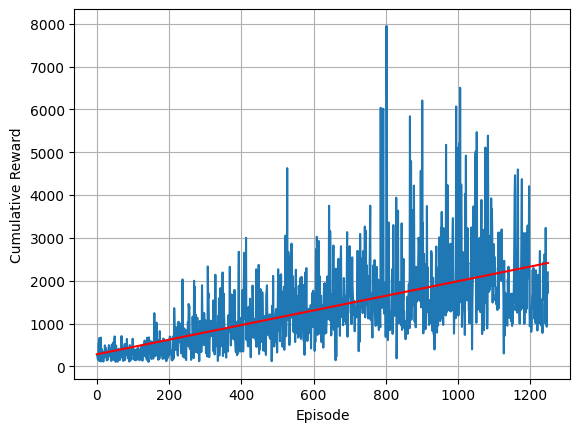

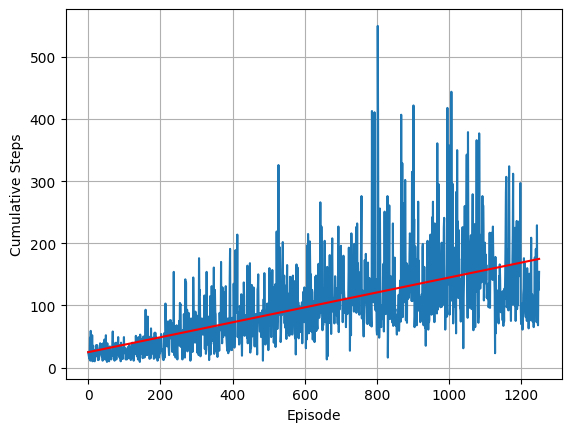

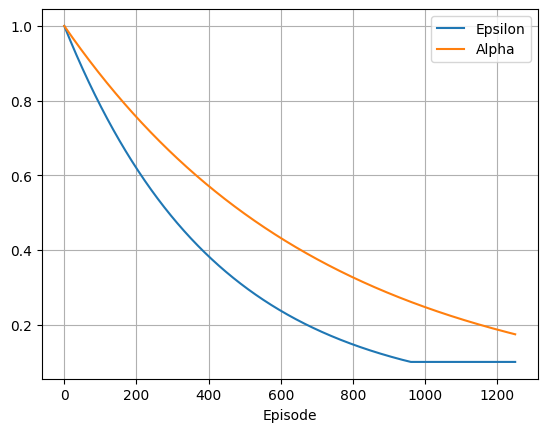

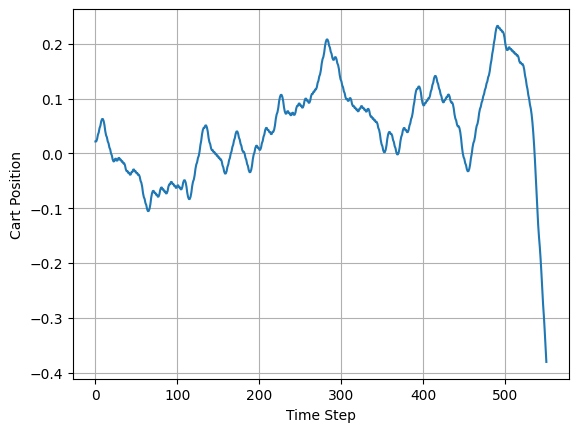

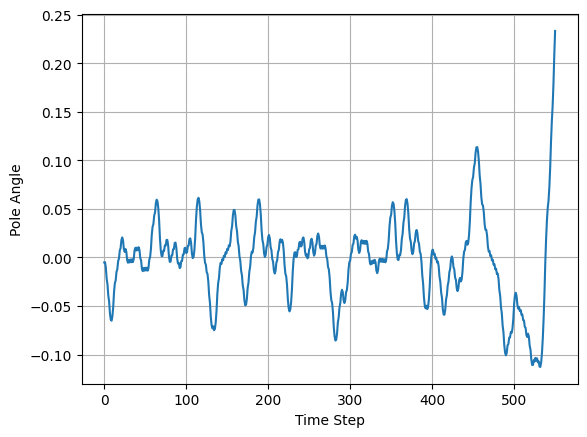

In [4]:
q_table, bins = Q_table(action_space,observation_space,num_bins)

Q_learning(q_table, bins, episodes, show_time, gamma, epsilon_i, epsilon_f, alpha_i, alpha_f, render_modes[1])